# Build a Long/Short Pairs Portfolio to maximum the PnL

1.   Base on **stocksInfo** and **researchData** only to **identify  Pairs** and calculate **trading parameters**. No additional data is allowed
2.   Based on **testData** to **backtest** the Pairs portfolio with **signals** and **dollarValue**
3.   Calculate the **PnL** of the backtested Pairs portfolio



# Rules
 

*   **No look-ahead bias**: The testData cannot be used for Pairs identification nor the trading parameters calculations. During backtest, can only refer to **look-back indicators**
*   **No overfitting**: The selected Pairs cannot be hand-picked and must be based on rules. Similarly for the trading parameters and dollarValue, apart from the obvious numbers (e.g. 0.05, 0.1, 0.5, 1, 100, 1000 etc.), they must be based on rules also.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

pd.set_option('display.max_column', None)
pd.set_option('display.max_row', None)
pd.set_option('display.width', 320)

%load_ext google.colab.data_table 
%matplotlib inline

!pip install swifter
!pip install swifter # first time installation
!pip install swifter[modin-ray] # first time installation including modin[ray]
!pip install swifter[modin-dask] # first time installation including modin[dask]
import swifter

!pip install -U openpyxl
import openpyxl

# Download and import pairslib for calculating PnL
!wget https://github.com/kenwkliu/ideas/raw/master/colab/pairslib.py
import pairslib

# Load the stockInfo, researchData and testData
stocksInfo = pd.read_excel('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/hkStocksQuotes.xlsx')
researchData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/researchHKStocksAdjClosePx.csv', index_col=0)
testData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/testHKStocksAdjClosePx.csv', index_col=0)


The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
--2022-02-02 06:54:45--  https://github.com/kenwkliu/ideas/raw/master/colab/pairslib.py
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/pairslib.py [following]
--2022-02-02 06:54:45--  https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/pairslib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2949 (2.9K) [text/plain]
Saving to: ‘pairslib.py.3’

pairslib.py.3       100%[===================>]   2.88K  --.-KB/s    in 0s      

2022-02-02 06:54:45

In [ ]:
CHART_SIZE_X, CHART_SIZE_Y = 12, 8
SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y = 8, 6

# Plot stock pair chart
def plotPair(df, stockA, stockB, sizeX, sizeY):
  ax1 = df[stockA].plot(label=stockA, legend=True, figsize = (sizeX, sizeY))
  ax1.set_ylim(df[stockA].min(), df[stockA].max())

  ax2 = df[stockB].plot(secondary_y=True, label=stockB, legend=True, figsize = (sizeX, sizeY))
  ax2.set_ylim(df[stockB].min(), df[stockB].max())

  ax1.legend(loc=2)
  ax2.legend(loc=1)

  plt.show()

# Plot all many Pairs at the same time
def plotManyPair(pairsDf):
  for index, row in pairsDf.iterrows():
      print('\n', index, ':', row['stockA'], 'vs', row['stockB'], '(', row['corr'], ')')
      plotPair(pairsDf, row['stockA'], row['stockB'], SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y)

# Filter the correlated stock pairs with the THRESHOLD
def getCorrelatedPairs(stocksCorr, THRESHOLD):
  # filter the pairs with correlation values above the THRESHOLD
  highCorr = stocksCorr[((stocksCorr >= THRESHOLD) & (stocksCorr < 1))]
  highCorr = highCorr.unstack().sort_values(ascending=False).drop_duplicates()
  highCorr.dropna(inplace=True)
  highCorrDf = highCorr.to_frame().reset_index()
  highCorrDf.rename(columns = {'level_0':'stockA', 'level_1':'stockB', 0:'corr'}, inplace=True)

  # looks up the sectors for the stocksA and stockB
  cols = ['stockA', 'stockB', 'corr', 'sector_A', 'sector_B']
  pairsDf = highCorrDf.merge(stocksFilteredInfo[['shortName', 'sector']], how='left', left_on='stockA', right_on='shortName').merge(stocksFilteredInfo[['shortName', 'sector']], how='left', left_on='stockB', right_on='shortName', suffixes=('_A', '_B'))[cols]
  pairsDf['sameSector'] = (pairsDf['sector_A'] == pairsDf['sector_B'])
  
  return pairsDf

# Check the stationarity
def stationarity(X, cutoff = 0.05):
  pvalue = adfuller(X)[1]
  if pvalue < cutoff:
    print('p-value = ', pvalue)
    print('The series ', X.name, ' is stationary')
  else:
    print('p-value = ', pvalue)
    print('The series ', X.name, ' non-stationary')

# Check cointegration relationship
def cointegration(X, Y, cutoff = 0.05):
  pvalue = coint(X, Y)[1]
  if coint(X, Y)[1] < cutoff:
    print('p-value = ', pvalue)
    print('The series are cointegrated')
  else:
    print('p-value = ', pvalue)
    print('The series are NOT cointegrated')

### back test related functions

# based on the reserch data to determind the trading params (Enter/Exit Points)
def researchTradingParams(researchData, stockA, stockB, threshold=0.3, dollarValue=20000):
  cols = [stockA, stockB]
  research_df = researchData[cols].copy()
  research_df.dropna(inplace = True)

  tradingParams = {}
  tradingParams['dollarValue'] = dollarValue

  # Calculate avgPxRatio for Exit (convergence)
  research_df['ratio'] = research_df[stockA] / research_df[stockB]
  avgPxRatio = research_df['ratio'].mean()
  tradingParams['avgPxRatio'] = avgPxRatio


  # Calculate shortA_longB_ratio for Entry (Divergence)
  shortA_longB_ratio = avgPxRatio * (1 + threshold)
  tradingParams['shortA_longB_ratio'] = shortA_longB_ratio

  # Calculate longA_shortB_ratio from Entry (Divergence)
  longA_shortB_ratio = avgPxRatio * (1 - threshold)
  tradingParams['longA_shortB_ratio'] = longA_shortB_ratio

  return tradingParams


# Determind the signal and dollarValue in the test data
# signal == -1: Long stockA Short stockB
# signal == 1: Short stockA Long stockB
# signal == 0: flat position
def backTest(testData, tradingParams, stockA, stockB):
  cols = [stockA, stockB]
  backTest_df = testData[cols].copy()
  backTest_df.dropna(inplace = True)

  # Get the tradingParams
  dollarValue = tradingParams['dollarValue']
  avgPxRatio = tradingParams['avgPxRatio']
  shortA_longB_ratio = tradingParams['shortA_longB_ratio']
  longA_shortB_ratio = tradingParams['longA_shortB_ratio']

  # Calculate the Price ratio in backTest_df
  backTest_df['pxRatio'] = backTest_df[stockA] / backTest_df[stockB]
  backTest_df['dollarValue'] = dollarValue
  
  # initialize the signal to 0
  backTest_df['signal'] = 0
  signal = 0

  # Determine the signal in each row of the backTest_df
  for index, row in backTest_df.iterrows():
    pxRatio = row['pxRatio']

    # mark signal = 1 if pxRatio > shortA_longB_ratio (Diverge outside the upper band)
    if pxRatio > shortA_longB_ratio:
      signal = 1

    # mark signal = -1 if pxRatio < longA_shortB_ratio (Diverge outside the lower band)
    elif pxRatio < longA_shortB_ratio:
      signal = -1

    else:
      # continue to mark signal = 1 if previous signal == 1 and pxRatio > avgPxRatio (Trade entered but not converge back yet)
      if signal == 1 and pxRatio > avgPxRatio:
        signal = 1

      # continue to mark signal = -1 if previous signal == -1 and pxRatio < avgPxRatio (Trade entered but not converge back yet)
      elif signal == -1 and pxRatio < avgPxRatio:
        signal = -1

      else:
        signal = 0

    backTest_df.loc[index, 'signal'] = signal

  return backTest_df


# determine pSignal and nSignal for up/down markers in plot
# pSignal and nSignal is for displaying the up/down markers in plotting chart only, they're not required for backtest calculation
def addSignalMarker(backTest_df):
  backTest_df['pSignal'] = np.where(backTest_df['signal'] == 1, backTest_df['pxRatio'], np.nan)
  backTest_df['nSignal'] = np.where(backTest_df['signal'] == -1, backTest_df['pxRatio'], np.nan)

  return backTest_df


# Combine the research and backtest for a Portfolio of Pairs
def researchAndBackTestPortfolio(pairsDf, researchData, testData, printOutput=True):
  pairsPortfolioBackTest = []

  for index, row in pairsDf.iterrows():
    stockA, stockB = row['stockA'], row['stockB']
    if printOutput: print(stockA, 'vs', stockB)
    tradingParams = researchTradingParams(researchData, stockA, stockB)
    pairsPortfolioBackTest.append(backTest(testData, tradingParams, stockA, stockB)[[stockA, stockB, 'signal', 'dollarValue']])

  return pairsPortfolioBackTest

In [ ]:
# list the unique industries names
industryNames = stocksInfo['industry'].unique()
print('Count: ', len(industryNames))
print(industryNames)

Count:  23
['Information Technology' 'Financial' 'Telecommunications' 'Energy'
 'Food and Beverage' 'Real Estate Construction' 'Meida and Communications'
 'Medicine' 'Betting' 'Transportation, logistics and infrastructure'
 'Consumer Goods Manufacturing' 'Conglomerate' 'Retail' 'Electricity'
 'Automobile production and distribution' 'Industry'
 'Environmental protection' 'Consumer Service' 'Industrial Products'
 'Raw Materials' 'Index leveraged products' 'Fund' 'ETF']


In [ ]:
# list the unique sector names
sectorNames = stocksInfo['sector'].unique()
print('Count:', len(sectorNames))
print(sectorNames)

Count: 123
['Telecommunications Equipment' 'Semi-conductor' 'Technology and Software'
 'E-commerce and Internet' 'Online and Mobile Games'
 'State-owned China banks' 'China Telecom' 'International Insurance'
 'Bank' 'China Insurance' 'Other financial services' 'Oil and gas'
 'Alcoholic Beverages' 'Real Estate Development'
 'Media Entertainment Culture Publishing' 'Pharmaceutical'
 'China Properties' 'Macau Gaming' 'Public Transport' 'Toys'
 'Conglomerate' 'Biotechnology' 'Sporting Goods'
 'Gas and Public Utilities' 'Catering' 'Electric utility' 'Supermarket'
 'small and medium China banks' 'Automobile' 'Mobile phone related'
 'Machinery' 'Dairy related' 'Textile and Clothing' 'Healthcare'
 'Property Management and Agent' 'Auto sales' 'Infrastructure'
 'Agricultural and Fishery products'
 'Food and beverage Production and Wholesale' 'Local Telecom'
 'Real Estate Investment' 'Water utilities' 'Jewelry Watches' 'Snack Food'
 'Cement' 'Clothing Accessories' 'Photovoltaic Solar' 'Packaged f

In [ ]:
# Exploring the data 
# Look at the subset of useful columns and sort by largest marketCap
SELECTED_COLUMNS = ['code', 'quoteType', 'shortName', 'industry', 'sector', 'marketCap', 'regularMarketPreviousClose', 'averageDailyVolume10Day']

print(stocksInfo[SELECTED_COLUMNS].sort_values(by=['marketCap'], ascending=False).head(20))

        code quoteType      shortName                industry                            sector     marketCap  regularMarketPreviousClose  averageDailyVolume10Day
2    4338.HK    EQUITY    MICROSOFT-T  Information Technology           Technology and Software  1.197435e+13                      500.00                      0.0
3    9988.HK    EQUITY        BABA-SW  Information Technology           E-commerce and Internet  5.370378e+12                      244.80               25690873.0
4    0700.HK    EQUITY        TENCENT  Information Technology           Online and Mobile Games  5.236233e+12                      535.00               20457768.0
14   1398.HK    EQUITY           ICBC               Financial           State-owned China banks  2.752837e+12                        4.65              161543498.0
11   2318.HK    EQUITY        PING AN               Financial                   China Insurance  1.820020e+12                       82.65               31290439.0
1    4335.HK    EQUITY

In [ ]:
# Before we look at the stock price correlation, select only liquid equity names for the trading purpose
# thus add a new colume 'turnover' 
stocksInfo['turnover'] = round(stocksInfo['regularMarketPreviousClose'] * stocksInfo['averageDailyVolume10Day'])

# Select only EQUITY and turnover is bigger than certain numbers
QUOTE_TYPE = 'EQUITY'
MIN_TURNOVER = 50000000  # 50 millions
SELECTED_COLUMNS = ['code', 'shortName', 'industry', 'sector', 'turnover']

stocksFilteredInfo = stocksInfo[(stocksInfo.quoteType == QUOTE_TYPE) & (stocksInfo.turnover > MIN_TURNOVER) & (stocksInfo.industry != 'ETF')].reset_index()
print(stocksFilteredInfo.sort_values(by=['turnover'], ascending=False)[SELECTED_COLUMNS].head(20))

        code      shortName                                industry                        sector      turnover
1    0700.HK        TENCENT                  Information Technology       Online and Mobile Games  1.094491e+10
0    9988.HK        BABA-SW                  Information Technology       E-commerce and Internet  6.289126e+09
28   0981.HK           SMIC                  Information Technology                Semi-conductor  5.881712e+09
3    3690.HK      MEITUAN-W                  Information Technology       E-commerce and Internet  4.727324e+09
8    0388.HK           HKEX                               Financial      Other financial services  2.732908e+09
7    2318.HK        PING AN                               Financial               China Insurance  2.586155e+09
11   1810.HK       XIAOMI-W                      Telecommunications  Telecommunications Equipment  2.374350e+09
34   1177.HK  SINO BIOPHARM                                Medicine                Pharmaceutical  1.415

In [ ]:
# Industry Distribution (diversity) with an interactive pie chart
import plotly.express as px

# Count the company names per industry
industryCount = stocksFilteredInfo[['industry', 'code']].groupby(['industry']).count().reset_index()
industryCount.rename(columns={'code' : 'count'}, inplace=True)

# Concat the company names per industry
industryStocks = stocksFilteredInfo[['industry', 'shortName']].groupby(['industry'])['shortName'].apply(', '.join).reset_index()

# Sum the marketCap and turnover per industry
industryDetails = stocksFilteredInfo[['industry', 'marketCap', 'turnover']].groupby(['industry']).sum().reset_index()

# Combine all in one dataframe
industryInfo = industryCount.merge(industryStocks, on='industry', how='left')
industryInfo = industryInfo.merge(industryDetails, on='industry', how='left')

fig = px.pie(industryInfo, values='count', names='industry', hover_name='shortName', title='Industry Distribution')
fig.show()

In [ ]:
# Industry Distribution table
print(industryInfo.sort_values(by=['count'], ascending=False))

                                        industry  count                                          shortName     marketCap      turnover
18                      Real Estate Construction     35  EVERGRANDE, SHK PPT, CHINA OVERSEAS, CHINA RES...  4.035190e+12  7.242322e+09
8                                      Financial     33  CCB, AIA, HSBC HOLDINGS, PING AN, HKEX, ICBC, ...  1.789736e+13  1.790965e+10
15                                      Medicine     33  ALI HEALTH, WUXI BIO, HANSOH PHARMA, SINO BIOP...  2.765934e+12  1.087772e+10
14                        Information Technology     25  BABA-SW, TENCENT, MEITUAN-W, SMIC, SUNNY OPTIC...  1.280417e+13  3.495633e+10
6                                         Energy     19  CNOOC, HK & CHINA GAS, CHINA GAS HOLD, ENN ENE...  3.137508e+12  4.131080e+09
0         Automobile production and distribution     15  GEELY AUTO, ZHONGSHENG HLDG, BYD COMPANY, SINO...  1.189581e+12  4.416475e+09
9                              Food and Beverage     13

In [ ]:
# Run the price correlation for all stock Pair combinations in research period
stocksCorr = researchData.corr()
stocksCorr.style.background_gradient(cmap='coolwarm', axis=None)

In [ ]:
# filter the pairs with correlation values above the THRESHOLD
THRESHOLD = 0.75
pairsDf = getCorrelatedPairs(stocksCorr, THRESHOLD)

print(pairsDf.round(4).head(20))

             stockA           stockB    corr                       sector_A                                    sector_B  sameSector
0       XINYI SOLAR       FLAT GLASS  0.9868             Photovoltaic Solar                               Glass strands       False
1         MEITUAN-W     MEIDONG AUTO  0.9813        E-commerce and Internet                                  Auto sales       False
2      ZIJIN MINING    MAN WAH HLDGS  0.9769                Precious metals                                  Housewares       False
3           TENCENT  ZHONGSHENG HLDG  0.9737        Online and Mobile Games                                  Auto sales       False
4       XINYI GLASS      XINYI SOLAR  0.9733                  Glass strands                          Photovoltaic Solar       False
5         MEITUAN-W  ZHONGSHENG HLDG  0.9731        E-commerce and Internet                                  Auto sales       False
6          XIAOMI-W    MAN WAH HLDGS  0.9697   Telecommunications Equipment 


 16 : FLAT GLASS vs XINYI GLASS ( 0.9655407434672915 )


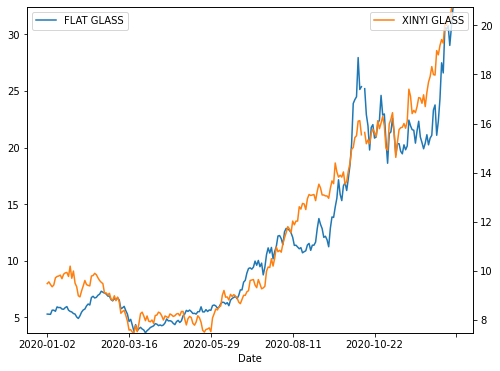


 27 : PHARMARON vs WUXI BIO ( 0.9609319290908578 )


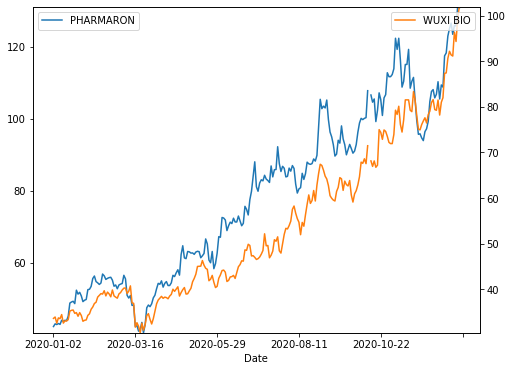


 28 : ZHONGSHENG HLDG vs MEIDONG AUTO ( 0.9599911709345492 )


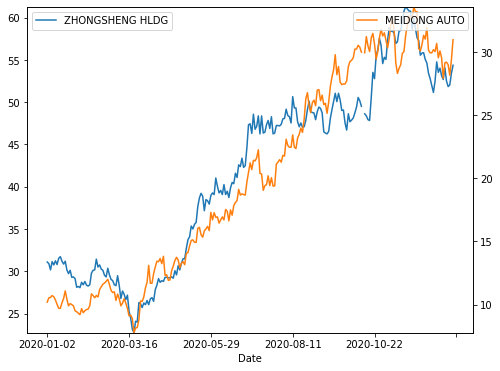


 33 : BANK OF CHINA vs ICBC ( 0.9572659748587914 )


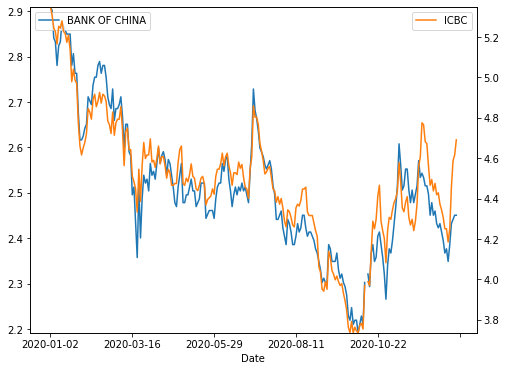


 34 : HANG SENG BANK vs HSBC HOLDINGS ( 0.9572511766426207 )


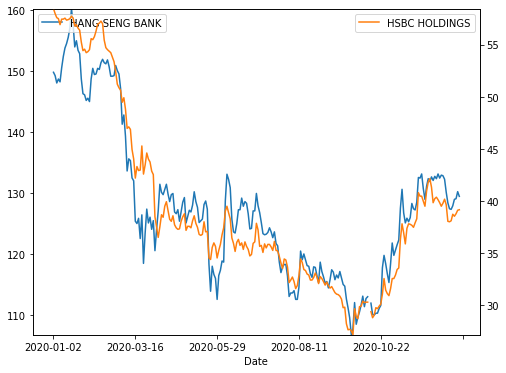


 52 : BYD COMPANY vs GREATWALL MOTOR ( 0.9522741312089321 )


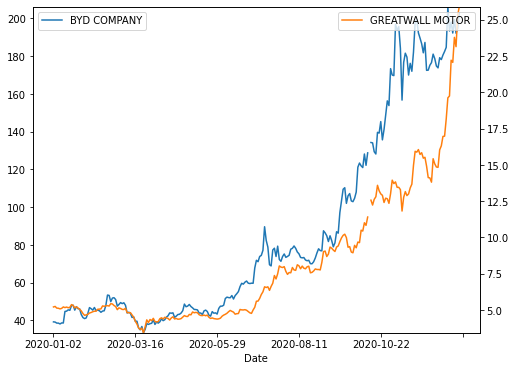


 58 : LI NING vs ANTA SPORTS ( 0.9511522694675245 )


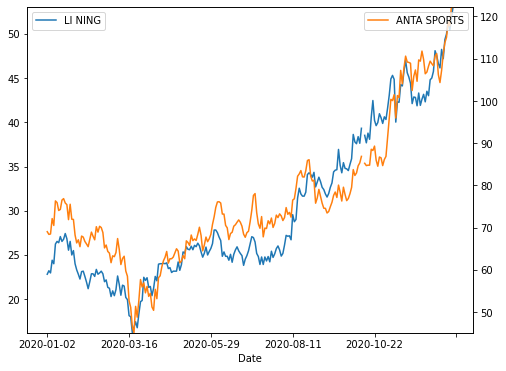


 60 : CG SERVICES vs EVERSUNSHINE LS ( 0.9507510955475679 )


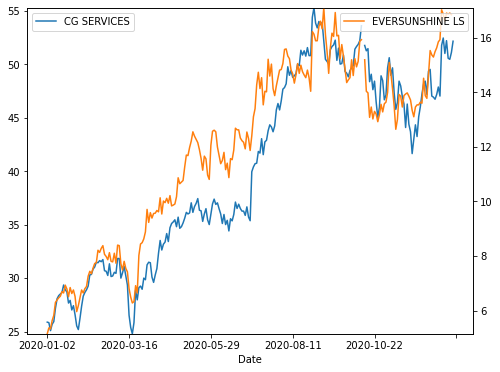


 74 : PETROCHINA vs CNOOC ( 0.9483452003546194 )


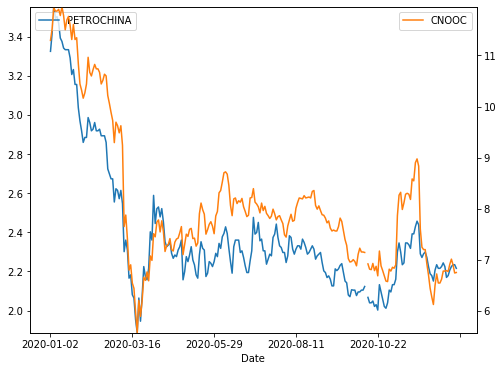


 98 : CHINA TELECOM vs CHINA UNICOM ( 0.9452586084913425 )


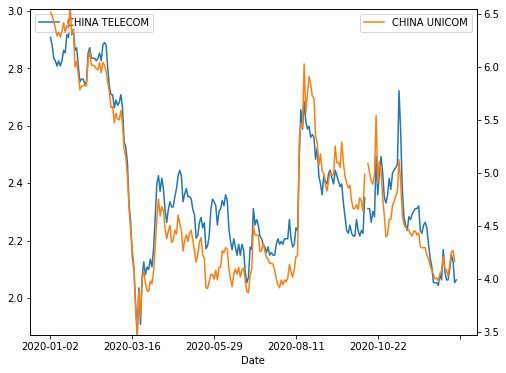


 99 : CHINA TAIPING vs PICC GROUP ( 0.9452489559772635 )


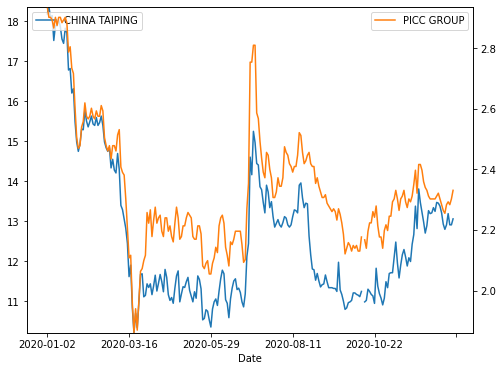


 103 : WYNN MACAU vs SANDS CHINA LTD ( 0.9446526324694837 )


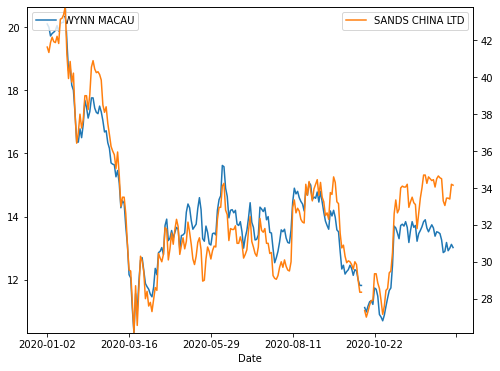


 119 : CHINA YOUZAN vs MEITUAN-W ( 0.940769465659127 )


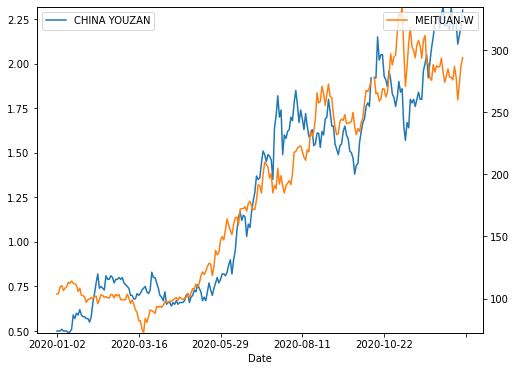


 120 : SINOPEC CORP vs PETROCHINA ( 0.9406297659283569 )


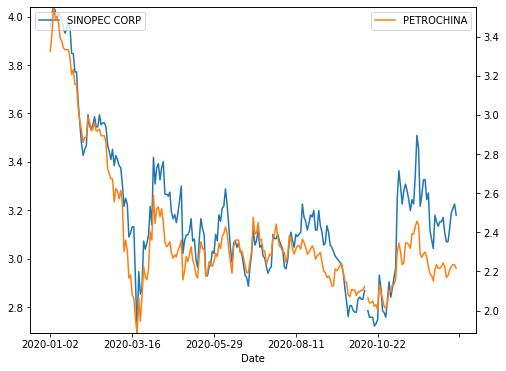


 217 : WEIGAO GROUP vs MICROPORT ( 0.9245942350493481 )


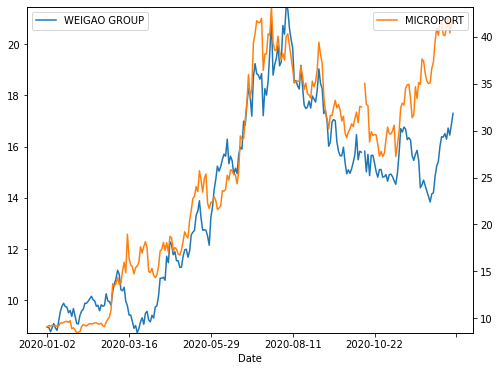


 273 : HKEX vs CSC ( 0.9189005434469355 )


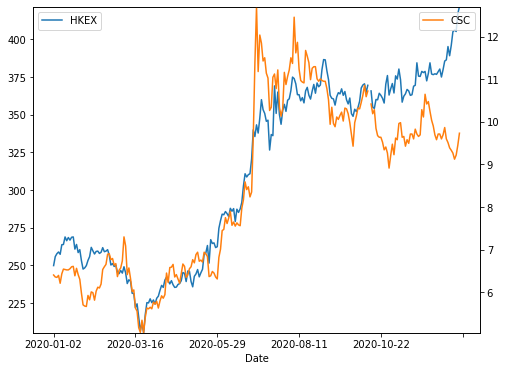


 301 : CHINA LIT vs MEITUAN-W ( 0.9168450847682081 )


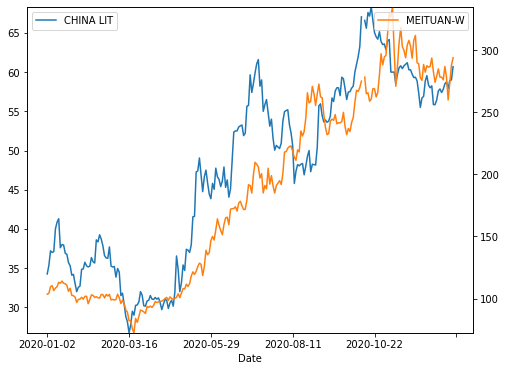


 322 : ICBC vs ABC ( 0.9136160317125933 )


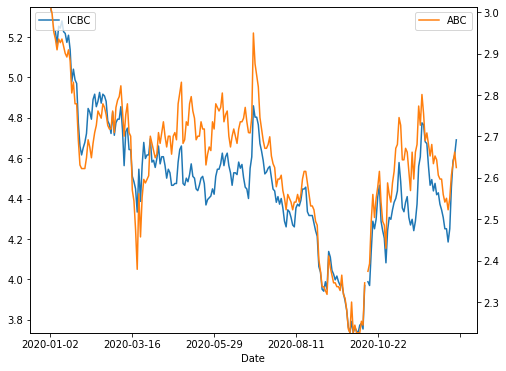


 327 : KINGSOFT vs KINGDEE INT'L ( 0.9132037796104243 )


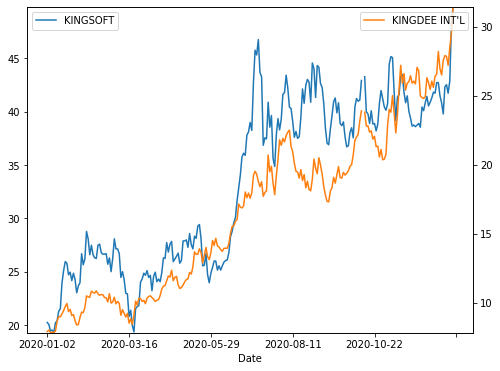


 331 : CITIC SEC vs CGS ( 0.9129461435326108 )


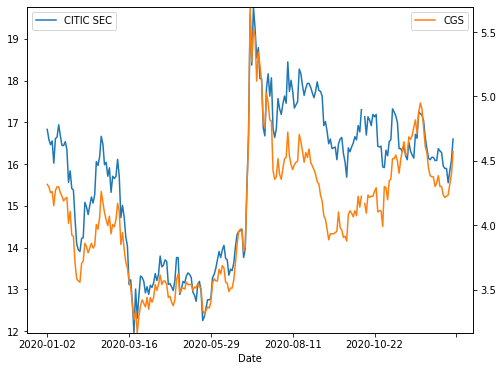


 333 : CPIC vs PING AN ( 0.9127433556309655 )


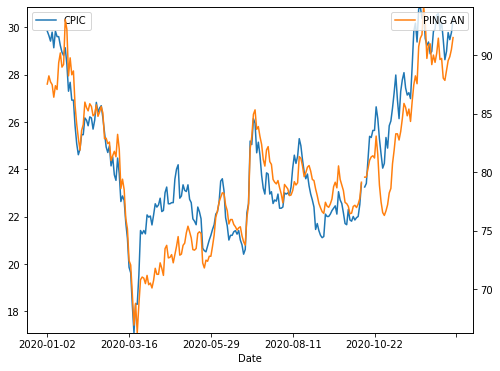


 395 : CCB vs ABC ( 0.9064936151217868 )


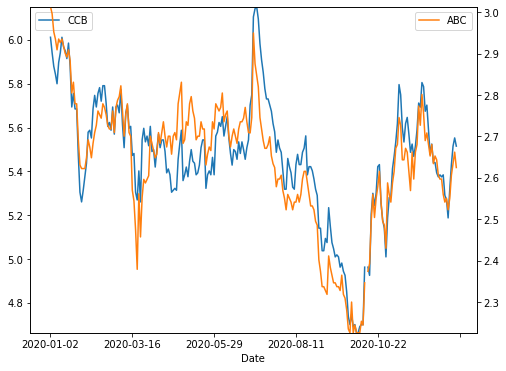


 402 : XD INC vs KINGSOFT ( 0.906100866791806 )


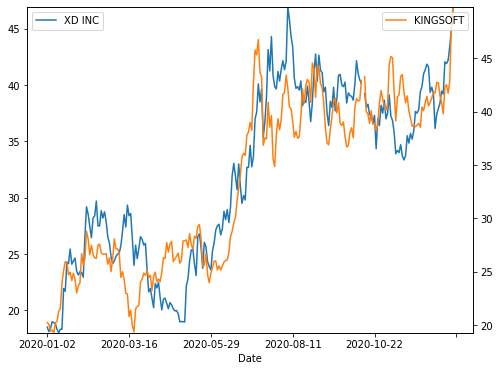


 407 : GEELY AUTO vs GREATWALL MOTOR ( 0.9052633013950837 )


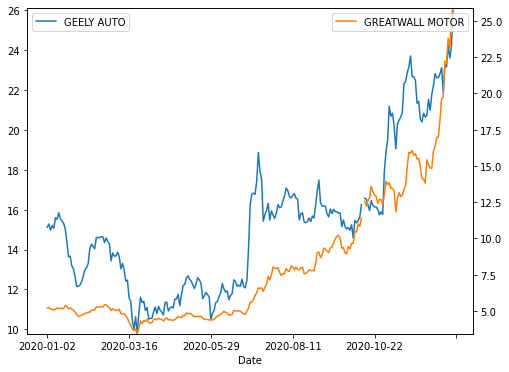


 430 : PA GOODDOCTOR vs CANSINOBIO-B ( 0.9036293005650484 )


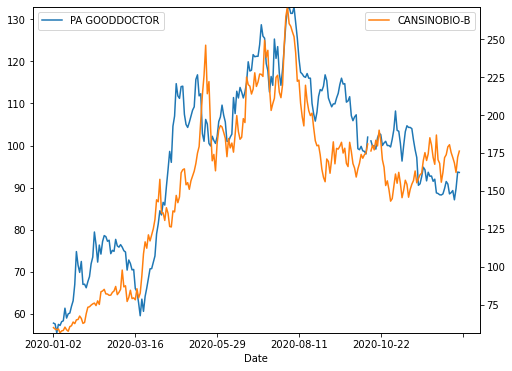


 479 : GEELY AUTO vs BYD COMPANY ( 0.8993061454870566 )


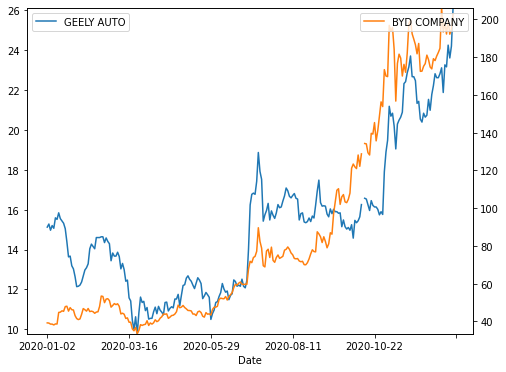


 560 : POLY PPT DEV vs A-LIVING ( 0.8916914413410634 )


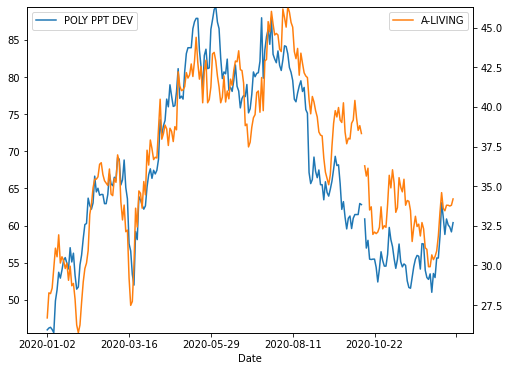


 563 : ICBC vs CCB ( 0.8912682622324632 )


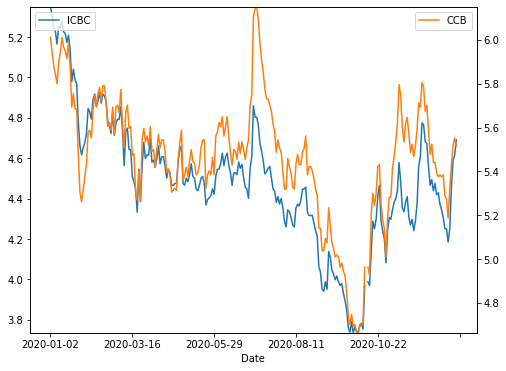


 569 : A-LIVING vs CC NEW LIFE ( 0.8903406671912203 )


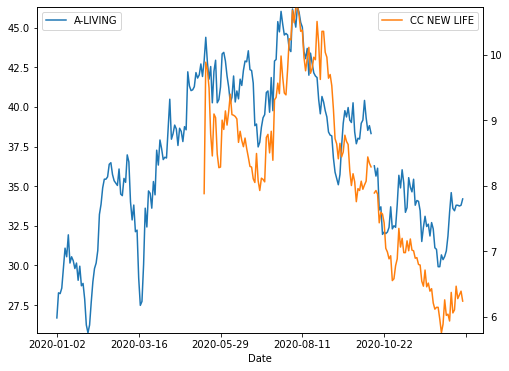


 573 : NCI vs CHINA LIFE ( 0.8900790865679941 )


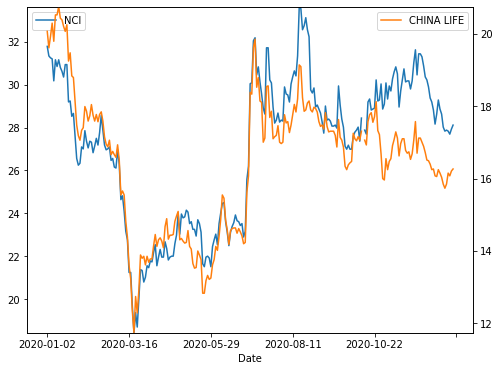


 613 : CSC vs EB SECURITIES ( 0.8866458901615519 )


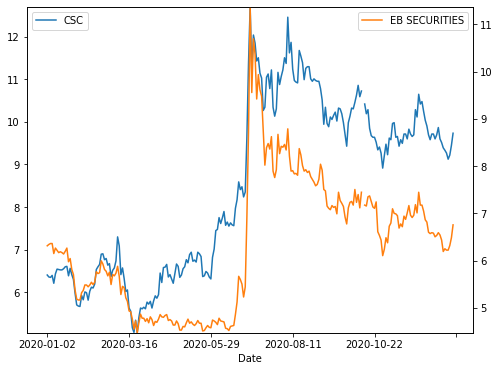


 632 : BABA-SW vs MEITUAN-W ( 0.8850296338268561 )


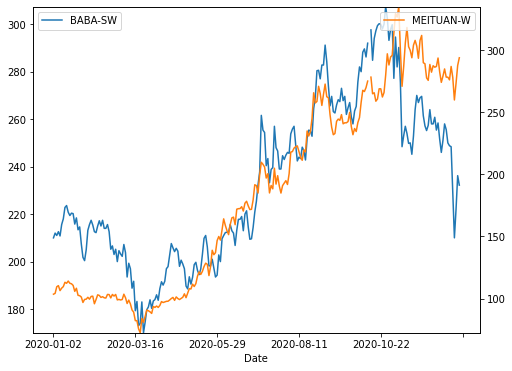


 676 : INNOVENT BIO vs HANSOH PHARMA ( 0.8808128889547834 )


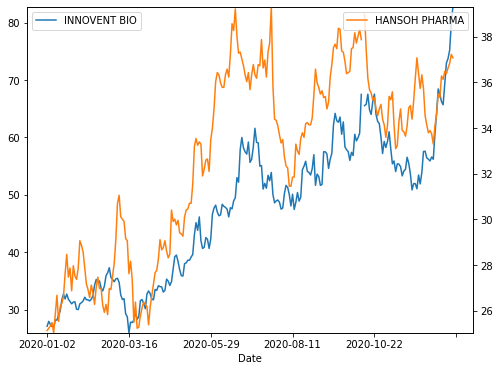


 684 : HANG SENG BANK vs BOC HONG KONG ( 0.880082881702948 )


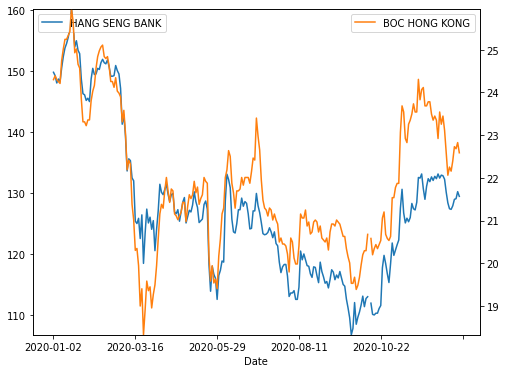


 704 : CHINA YOUZAN vs CHINA LIT ( 0.87861631103764 )


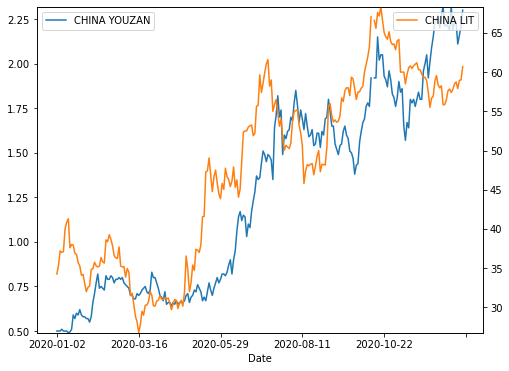


 797 : GALAXY ENT vs SJM HOLDINGS ( 0.8703001913567141 )


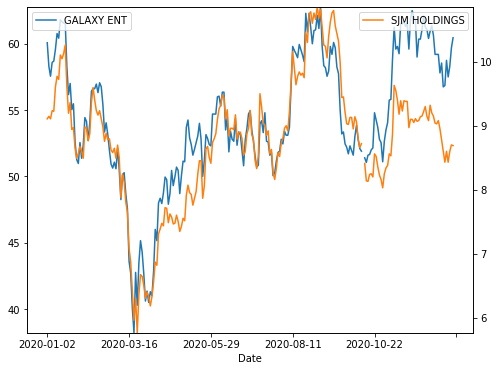


 818 : WUXI APPTEC vs MICROPORT ( 0.8687965400156821 )


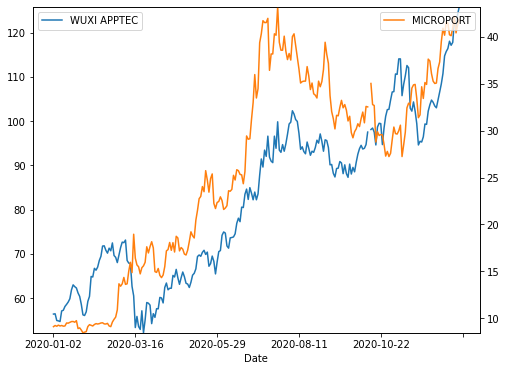


 847 : BANK OF CHINA vs ABC ( 0.8664071160834791 )


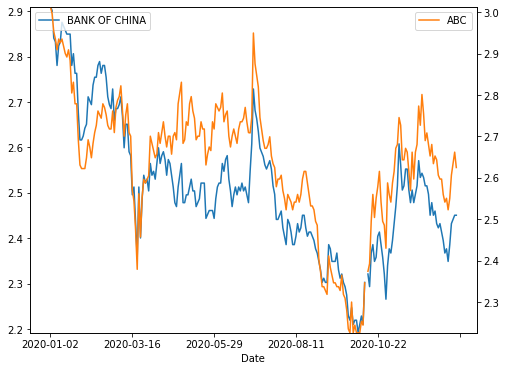


 863 : CNOOC vs SINOPEC CORP ( 0.8648130107396442 )


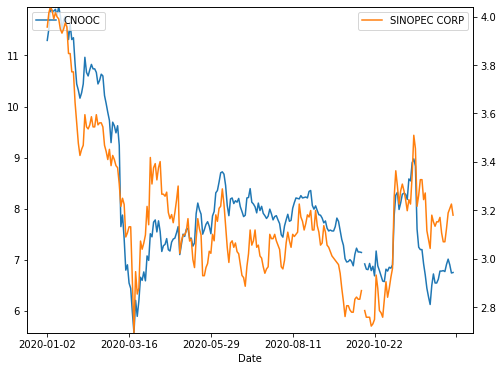


 928 : CANSINOBIO-B vs WEIGAO GROUP ( 0.8601169399006877 )


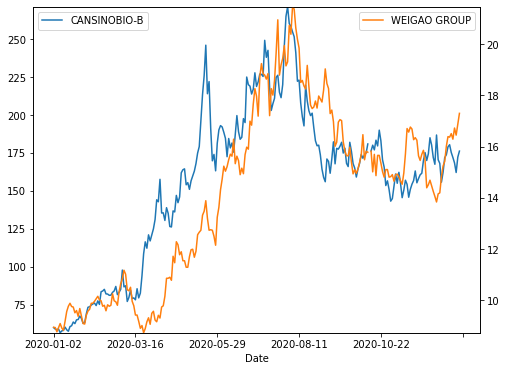


 954 : ZHONGSHENG HLDG vs YONGDA AUTO ( 0.858155847233638 )


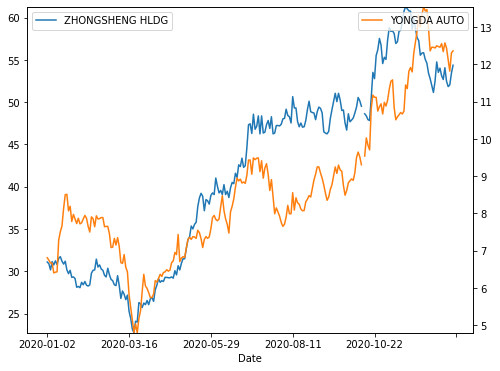


 973 : GEELY AUTO vs DONGFENG GROUP ( 0.8572993787378304 )


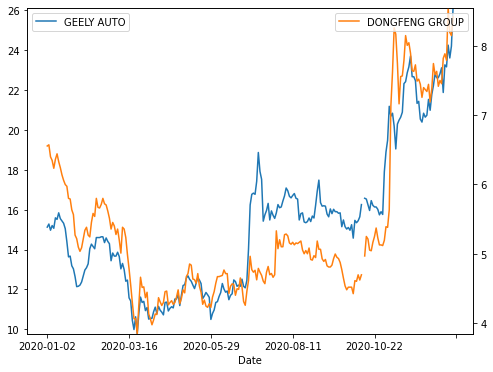


 977 : CHINASOFT INT'L vs KINGDEE INT'L ( 0.8569124895607882 )


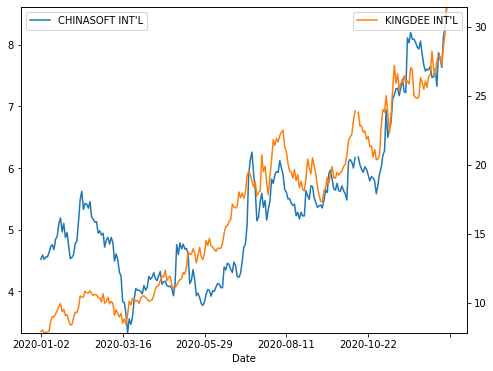


 978 : BABA-SW vs CHINA LIT ( 0.8568841266075293 )


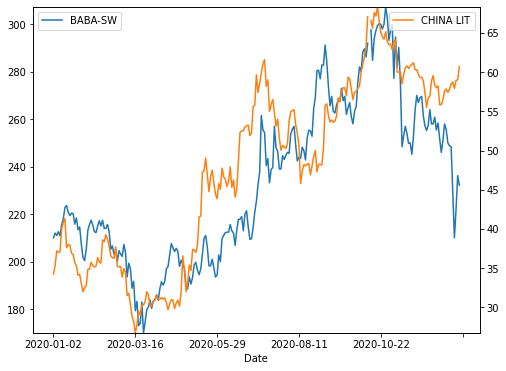


 994 : CCB vs BANK OF CHINA ( 0.8556475529013485 )


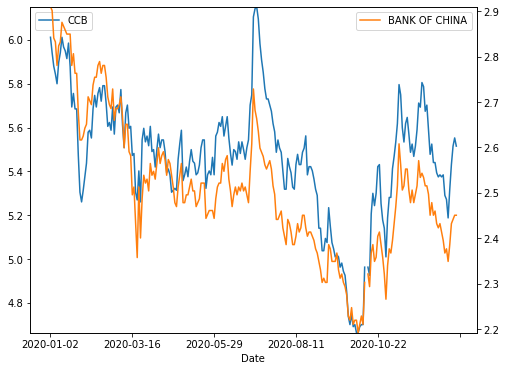


 1003 : SUNAC vs CHINA OVERSEAS ( 0.8549972553603685 )


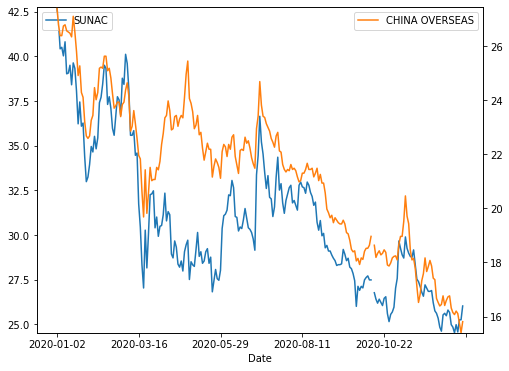


 1042 : PA GOODDOCTOR vs WEIGAO GROUP ( 0.8526471482740205 )


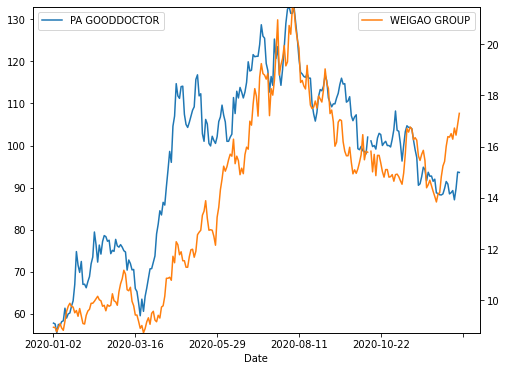


 1057 : KINGDEE INT'L vs XD INC ( 0.8517630171337659 )


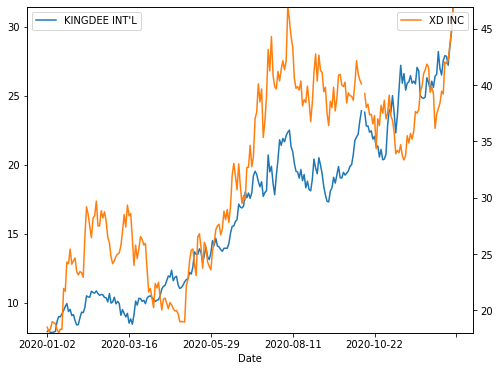


 1151 : MEIDONG AUTO vs YONGDA AUTO ( 0.8439772159268887 )


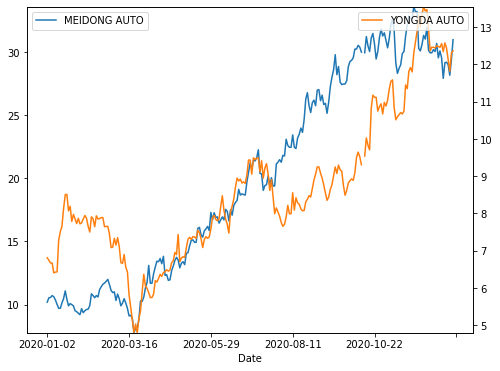


 1200 : ZOOMLION vs TECHTRONIC IND ( 0.8406527287856612 )


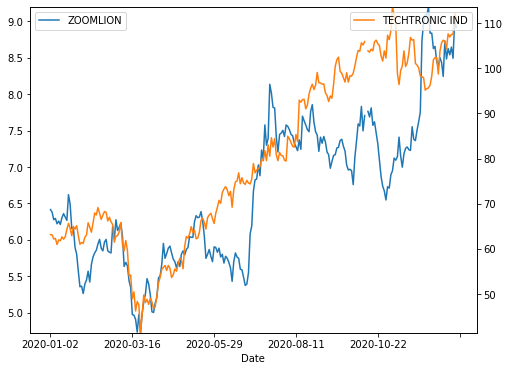


 1221 : CHINARES CEMENT vs CNBM ( 0.8391337629471609 )


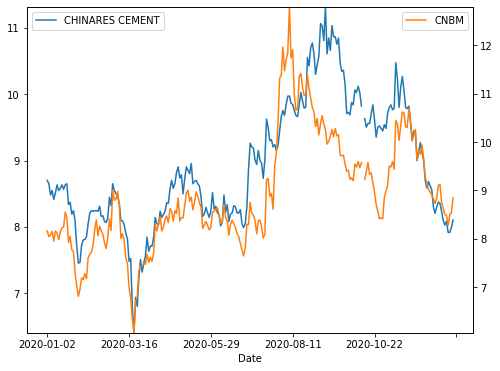


 1317 : ZTE vs CHINA TOWER ( 0.8316864268496679 )


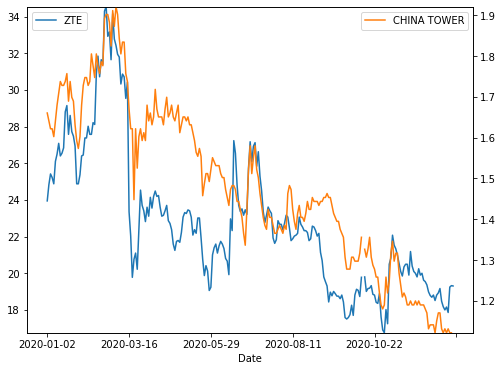


 1338 : CANSINOBIO-B vs MICROPORT ( 0.8295872957451763 )


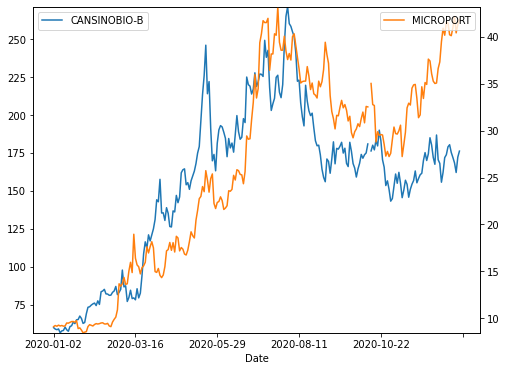


 1385 : ALI HEALTH vs INNOVENT BIO ( 0.8267896730355692 )


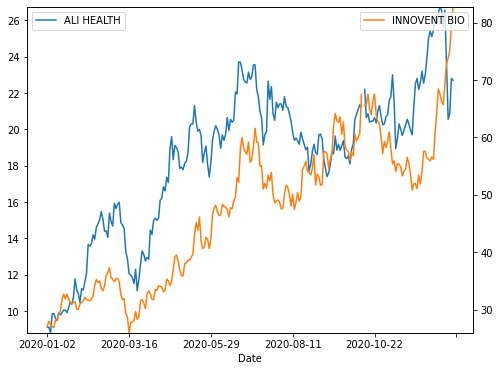


 1386 : PICC GROUP vs CHINA LIFE ( 0.8267844895121716 )


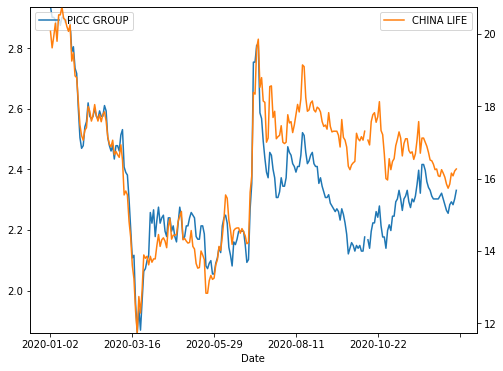


 1441 : ALI HEALTH vs HANSOH PHARMA ( 0.8223947854561091 )


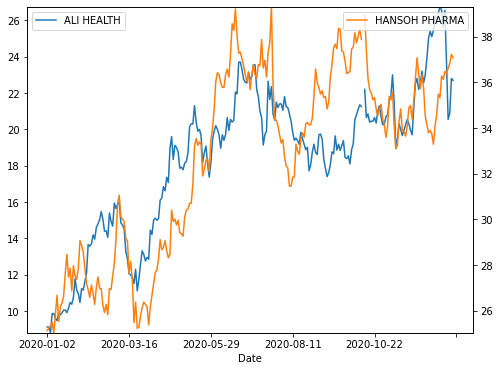


 1448 : BABA-SW vs CHINA YOUZAN ( 0.8218878103285256 )


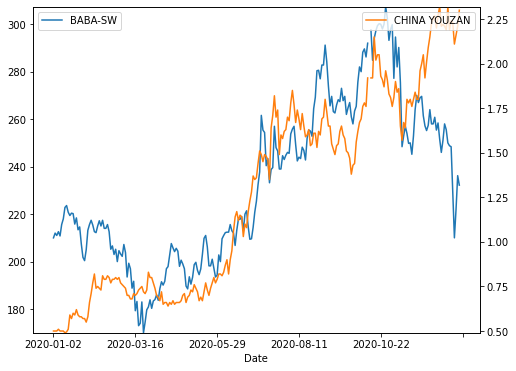


 1480 : HENGTEN NET vs XINYI SOLAR ( 0.8195522629771398 )


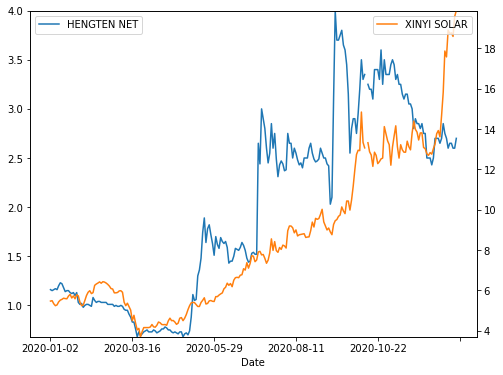


 1535 : HK & CHINA GAS vs BEIJING ENT ( 0.8152670578729905 )


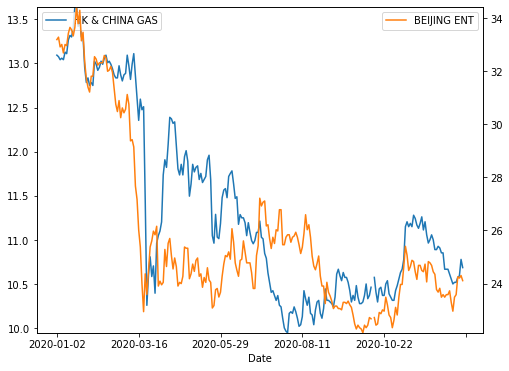


 1568 : CHINA MOBILE vs CHINA TELECOM ( 0.8128094446382731 )


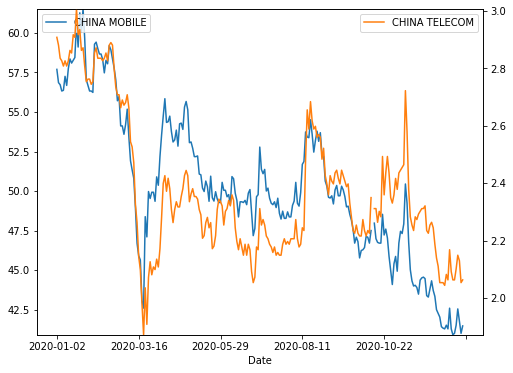


 1623 : INNOVENT BIO vs FOSUN PHARMA ( 0.8068984695637642 )


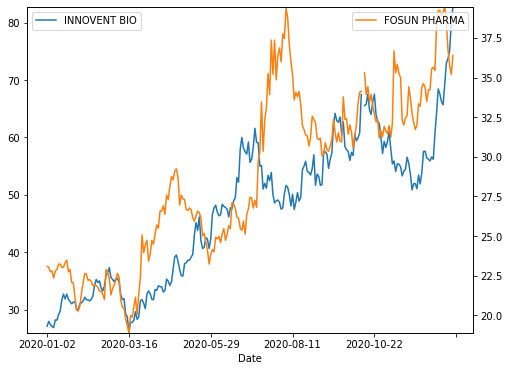


 1635 : PICC P&C vs CHINA TAIPING ( 0.8059876671069978 )


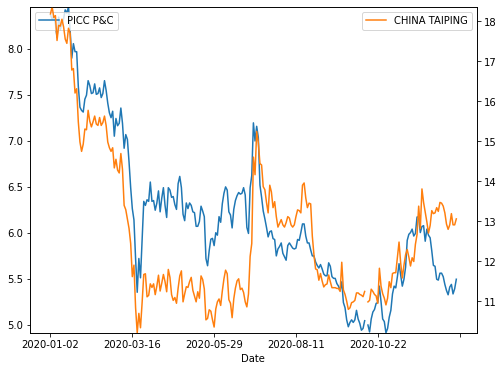


 1693 : AK MEDICAL vs PA GOODDOCTOR ( 0.801655136978329 )


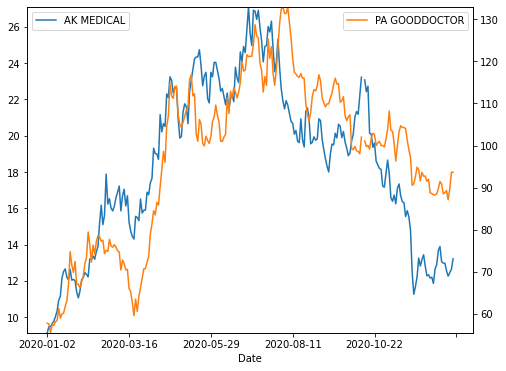


 1774 : VIVA BIOTECH vs PHARMARON ( 0.7949590802006715 )


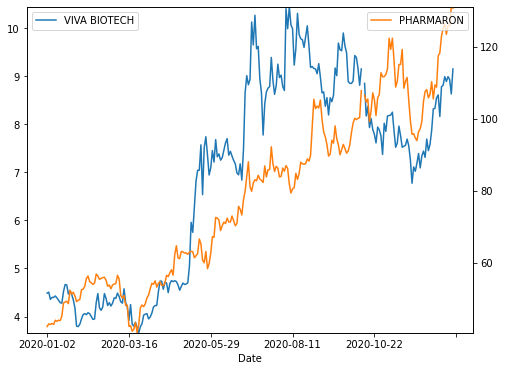


 1797 : TECHTRONIC IND vs BROAD HOMES ( 0.7931105217905978 )


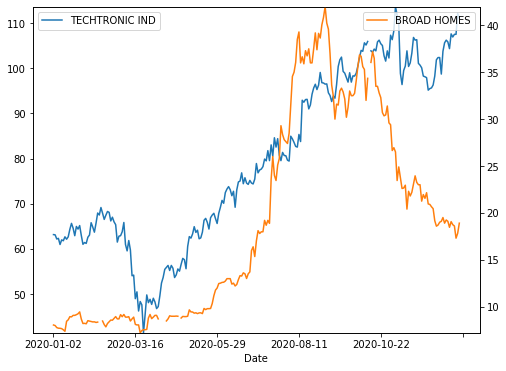


 1800 : HUABAO INTL vs YIHAI INTL ( 0.7926005734523633 )


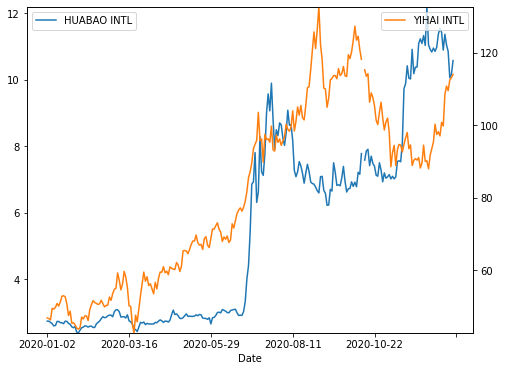


 1845 : WUXI APPTEC vs WEIGAO GROUP ( 0.7878278900406892 )


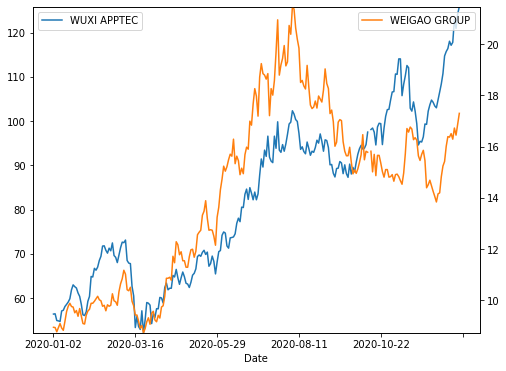


 2078 : CC NEW LIFE vs POLY PPT DEV ( 0.7697338225029685 )


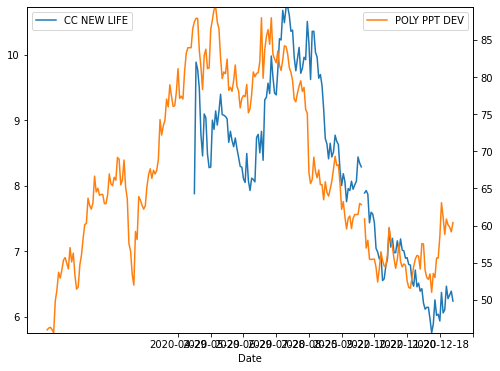


 2098 : CHINA JINMAO vs CK ASSET ( 0.768468445971753 )


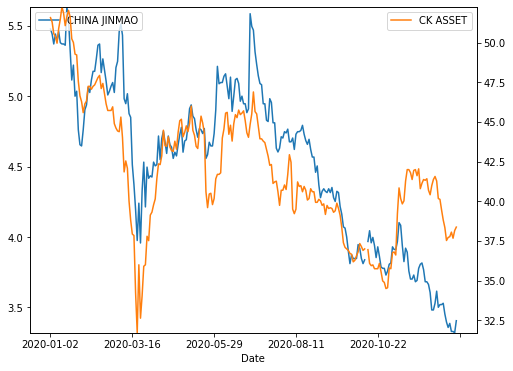


 2124 : HSBC HOLDINGS vs BOC HONG KONG ( 0.7669747196988278 )


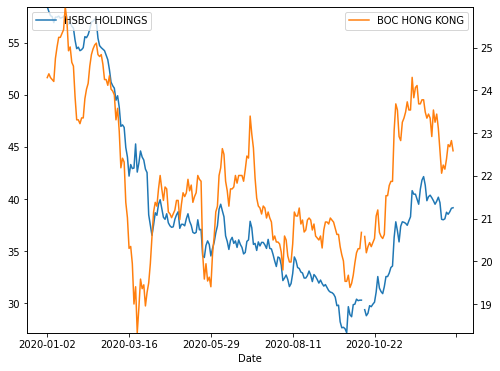


 2153 : FOSUN PHARMA vs ALI HEALTH ( 0.7652448202406047 )


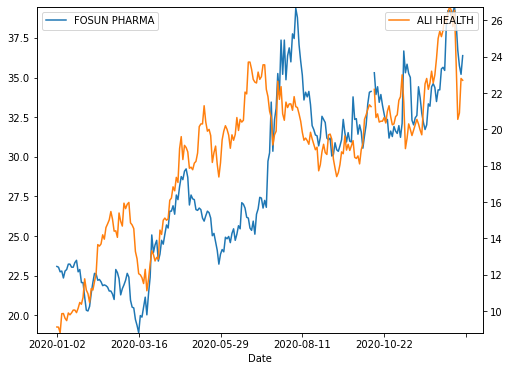


 2178 : KINGSOFT vs CHINASOFT INT'L ( 0.763617982708835 )


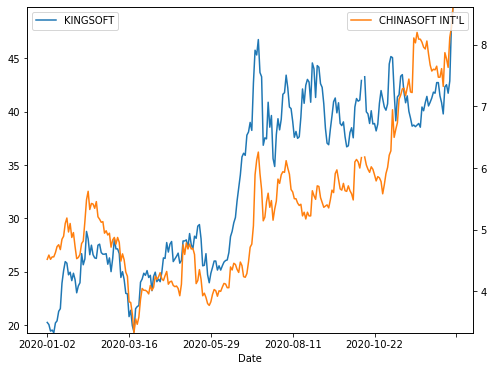


 2247 : GREATWALL MOTOR vs DONGFENG GROUP ( 0.7591277980131811 )


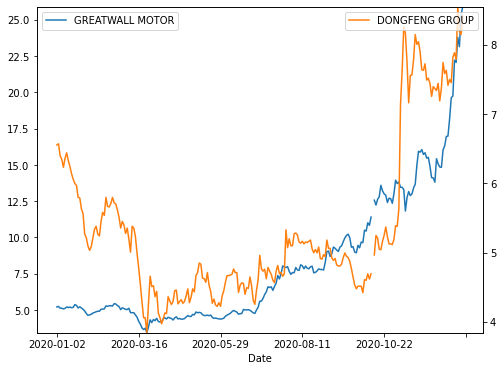


 2270 : PICC P&C vs PICC GROUP ( 0.7571658249556612 )


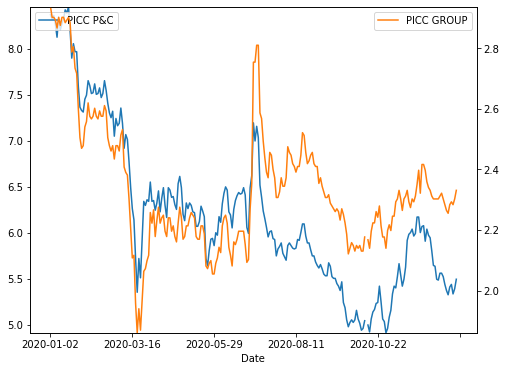


 2316 : EB SECURITIES vs HKEX ( 0.7536078278499858 )


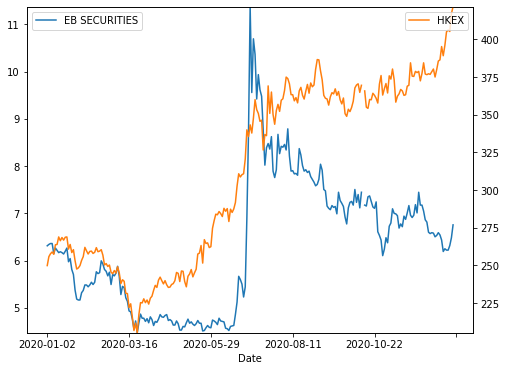

In [ ]:
# Pick a stock pair price chart to to show the price correlation
selected_pair = 34

# Plot all Pairs
for index, row in pairsDf.iterrows():
  if row['sameSector'] == True:
    print('\n', index, ':', pairsDf.loc[index]['stockA'], 'vs', pairsDf.loc[index]['stockB'], '(', pairsDf.loc[index]['corr'], ')')
    PAIR_STOCK_A = pairsDf.loc[index]['stockA']
    PAIR_STOCK_B = pairsDf.loc[index]['stockB']
    plotPair(researchData, PAIR_STOCK_A, PAIR_STOCK_B, SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y)

PAIR_STOCK_A = pairsDf.loc[selected_pair]['stockA']
PAIR_STOCK_B = pairsDf.loc[selected_pair]['stockB']


In [ ]:
# Running the price ratio which represent the relative price value
# Calculate the stock price ratios of (Stock A / Stock B) over the research period
pairResearchData = researchData[[PAIR_STOCK_A, PAIR_STOCK_B]].copy()

AB_stock = PAIR_STOCK_A + " / " + PAIR_STOCK_B
pairResearchData[AB_stock] = pairResearchData[PAIR_STOCK_A] / pairResearchData[PAIR_STOCK_B]

In [ ]:
# Check the stationarity of the pair and ratio
coint_check = pairResearchData[[PAIR_STOCK_A, PAIR_STOCK_B, AB_stock]].copy()

coint_check.dropna(inplace=True)

stationarity(coint_check[PAIR_STOCK_A])
stationarity(coint_check[PAIR_STOCK_B])
stationarity(coint_check[AB_stock])

# Check if the price of the pair is cointegrated
cointegration(coint_check[PAIR_STOCK_A], coint_check[PAIR_STOCK_B])

p-value =  0.29405505925315545
The series  HANG SENG BANK  non-stationary
p-value =  0.13093111748215142
The series  HSBC HOLDINGS  non-stationary
p-value =  0.24175645142196872
The series  HANG SENG BANK / HSBC HOLDINGS  non-stationary
p-value =  0.005249281924142959
The series are cointegrated


**Trading Logic**
1. *Strategy*:
*   Long Stock A and Short Stock B when the price ratio diverge outside the lower band
*   Short Stock A and Long Stock B when the price ratio diverge outside the upper band
*   Upper band and lower band are determined by the mean of price ratio over the training dataset period plus/minus pre-determined threshold

2. *Pair Selection Criteria*:
*   Price ratio is cointergrated
*   Price Correlation > 0.75
*   10-day average turnover > HKD50mil

3. *Parameters:*
*   Threshold for upper band and lower band = 0.3
*   10,000 dollar for each pair

In [ ]:
# Check stationarity and cointegration for all pairs
coint_researchData = researchData.copy()
coint_researchData.dropna(inplace=True)
coint_df = pairsDf.copy()
coint_df['ADF'] = coint_df.swifter.apply(lambda row: adfuller((coint_researchData[row.stockA]/coint_researchData[row.stockB]))[1], axis=1)
coint_df['coint'] = coint_df.swifter.apply(lambda row: coint(coint_researchData[row.stockA], coint_researchData[row.stockB])[1], axis =1)
print(coint_df.head(20))

Dask Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/4 [00:00<?, ?it/s]

             stockA           stockB      corr                       sector_A                                    sector_B  sameSector       ADF     coint
0       XINYI SOLAR       FLAT GLASS  0.986801             Photovoltaic Solar                               Glass strands       False  0.437175  0.658789
1         MEITUAN-W     MEIDONG AUTO  0.981320        E-commerce and Internet                                  Auto sales       False  0.001785  0.013963
2      ZIJIN MINING    MAN WAH HLDGS  0.976942                Precious metals                                  Housewares       False  0.004253  0.002097
3           TENCENT  ZHONGSHENG HLDG  0.973716        Online and Mobile Games                                  Auto sales       False  0.018731  0.003576
4       XINYI GLASS      XINYI SOLAR  0.973291                  Glass strands                          Photovoltaic Solar       False  0.366671  0.416239
5         MEITUAN-W  ZHONGSHENG HLDG  0.973143        E-commerce and Interne

In [ ]:
# Filter out non-cointergrated pairs
pvalue_threshold = 0.05
pairs_coint_df = coint_df[(coint_df['coint'] < pvalue_threshold)]
pairs_coint_df = pairs_coint_df.reset_index()
print(pairs_coint_df.head(20))

    index           stockA           stockB      corr                      sector_A                      sector_B  sameSector       ADF     coint
0       1        MEITUAN-W     MEIDONG AUTO  0.981320       E-commerce and Internet                    Auto sales       False  0.001785  0.013963
1       2     ZIJIN MINING    MAN WAH HLDGS  0.976942               Precious metals                    Housewares       False  0.004253  0.002097
2       3          TENCENT  ZHONGSHENG HLDG  0.973716       Online and Mobile Games                    Auto sales       False  0.018731  0.003576
3      12     ZIJIN MINING    MENGNIU DAIRY  0.967067               Precious metals                 Dairy related       False  0.497549  0.001052
4      14         WUXI BIO    MAN WAH HLDGS  0.966552                 Biotechnology                    Housewares       False  0.002784  0.012061
5      15      XINYI GLASS         XIAOMI-W  0.965878                 Glass strands  Telecommunications Equipment       Fals

In [ ]:
selectedPairsDf = pairs_coint_df
print("Total pairs for backtesting:", len(selectedPairsDf))
print('----------------------------------------------------------')

# Research the trading params and back test the selected Pairs in test period
pairsPortfolioBackTest = researchAndBackTestPortfolio(selectedPairsDf, researchData, testData, printOutput=False)

# look at one of the pairs backtest results
# Each backtested Pairs is a dataframe with these columns (Date, stockA, stockB, signal, dollarValue)
pairsPortfolioBackTest[0]

# Calcuate the PnL of the Pairs portfolio
pnl, pnlDf = pairslib.calcPortfolio(pairsPortfolioBackTest)
pnlDf

Total pairs for backtesting: 164
----------------------------------------------------------
MEITUAN-W vs MEIDONG AUTO ---> $ 5300.8060573258845
ZIJIN MINING vs MAN WAH HLDGS ---> $ 5031.288703996637
TENCENT vs ZHONGSHENG HLDG ---> $ 3271.598117587555
ZIJIN MINING vs MENGNIU DAIRY ---> $ 124.00768610237355
WUXI BIO vs MAN WAH HLDGS ---> $ -3196.593315546739
XINYI GLASS vs XIAOMI-W ---> $ -3809.6764300382238
LI NING vs XINYI GLASS ---> $ 7861.182390548347
XIAOMI-W vs WUXI BIO ---> $ -3807.562466759591
WUXI BIO vs LI NING ---> $ 10589.841762727636
CHINA YOUZAN vs KINGDEE INT'L ---> $ -1454.7972342776247
TECHTRONIC IND vs MEIDONG AUTO ---> $ 7207.414384865868
HANG SENG BANK vs HSBC HOLDINGS ---> $ 0
WUXI BIO vs XINYI GLASS ---> $ 3962.7485013027763
GEELY AUTO vs ZIJIN MINING ---> $ 96.96975092298999
TIANNENG POWER vs MICROPORT ---> $ -7102.161591814753
ZIJIN MINING vs CHINASOFT INT'L ---> $ 3272.1311975389435
BYD ELECTRONIC vs HAIDILAO ---> $ -2126.6092648135764
CHINASOFT INT'L vs GEELY AU

stockA          stocksB           Pnl
0          MEITUAN-W     MEIDONG AUTO   5300.806057
1       ZIJIN MINING    MAN WAH HLDGS   5031.288704
2            TENCENT  ZHONGSHENG HLDG   3271.598118
3       ZIJIN MINING    MENGNIU DAIRY    124.007686
4           WUXI BIO    MAN WAH HLDGS  -3196.593316
5        XINYI GLASS         XIAOMI-W  -3809.676430
6            LI NING      XINYI GLASS   7861.182391
7           XIAOMI-W         WUXI BIO  -3807.562467
8           WUXI BIO          LI NING  10589.841763
9       CHINA YOUZAN    KINGDEE INT'L  -1454.797234
10    TECHTRONIC IND     MEIDONG AUTO   7207.414385
11    HANG SENG BANK    HSBC HOLDINGS      0.000000
12          WUXI BIO      XINYI GLASS   3962.748501
13        GEELY AUTO     ZIJIN MINING     96.969751
14    TIANNENG POWER        MICROPORT  -7102.161592
15      ZIJIN MINING  CHINASOFT INT'L   3272.131198
16    BYD ELECTRONIC         HAIDILAO  -2126.609265
17   CHINASOFT INT'L       GEELY AUTO  -2176.799252
18    BYD ELECTRONIC   TECHTRONIC IND   7314.279761
19         SINOPHARM       PETROCHINA  -1140.776897
20       BEIJING ENT       CITIC BANK      0.000000
21        WEIMOB INC   TIANNENG POWER   1693.092173
22      CHINA JINMAO   CHINA OVERSEAS   -471.403166
23      MEIDONG AUTO             HKTV   8545.682175
24      VIVA BIOTECH   TIANNENG POWER  11861.900856
25     HUA HONG SEMI   CHINA RES BEER    629.707502
26          ZOOMLION      HUABAO INTL -13742.559911
27               ESR    SHENZHOU INTL   2839.388046
28    TECHTRONIC IND         HAIDILAO -11434.372535
29         PHARMARON      XINYI SOLAR  11341.159183
30            XD INC   MEILAN AIRPORT  18372.469231
31      SINOPEC CORP     CKH HOLDINGS      0.000000
32     MENGNIU DAIRY      WUXI APPTEC    475.383865
33    TECHTRONIC IND              ESR  -5477.299916
34    TECHTRONIC IND             HKTV  13607.132683
35               ESR         HAIDILAO   3045.903533
36       BEIJING ENT       PETROCHINA    729.949331
37     MENGNIU DAIRY    KINGDEE INT'L   4542.949911
38      EVERG HEALTH           XD INC  -7131.583592
39      CHINA YOUZAN    MENGNIU DAIRY   1174.785498
40     CHINA SHENHUA    MENGNIU DAIRY      0.000000
41     KINGDEE INT'L     ZIJIN MINING   1920.819229
42     SHENZHOU INTL         HAIDILAO  -6079.557223
43              ICBC              ABC      0.000000
44     TSINGTAO BREW         ZOOMLION   8809.982016
45     EB SECURITIES        ZA ONLINE   5481.856995
46       CHINA FEIHE     MEIDONG AUTO  -8407.815556
47        PETROCHINA       CITIC BANK  -3251.620477
48       HUABAO INTL      WUXI APPTEC   4751.540209
49           SD GOLD       COFCO MEAT   2857.494130
50               CCB              ABC      0.000000
51           BABA-SW      HENGTEN NET  -1607.819653
52          KINGSOFT     EVERG HEALTH  -7900.237689
53     HUA HONG SEMI   GANFENGLITHIUM  -5768.699803
54          AVICHINA   TIANNENG POWER    702.452441
55      CONCH CEMENT      CC NEW LIFE   6522.000483
56       WUXI APPTEC     ZIJIN MINING   5717.755494
57               CSC          SD GOLD   3710.351339
58      CANSINOBIO-B         HOPE EDU -14116.812139
59    DONGFENG GROUP          CM BANK   6528.526095
60         SINOPHARM         PICC P&C      0.000000
61          CK ASSET         PICC P&C      0.000000
62         SINOPHARM       CITIC BANK      0.000000
63      FOSUN PHARMA     EVERG HEALTH   5842.908641
64          ND PAPER          LI NING -11583.680467
65       FUYAO GLASS       FLAT GLASS  -2184.132502
66   MTR CORPORATION        LINK REIT      0.000000
67        PICC GROUP      HAITONG SEC      0.000000
68               CSC    EB SECURITIES      0.000000
69     CHINA TAIPING      ASM PACIFIC      0.000000
70     LONGFOR GROUP     MEIDONG AUTO  -8739.446468
71              CICC     EVERG HEALTH  -8703.826341
72       HUABAO INTL  ZHONGSHENG HLDG  -6448.427472
73               AIA      FUYAO GLASS   -828.840788
74     LONGFOR GROUP        MEITUAN-W  -1323.546375
75     CHINA SHENHUA       GEELY AUTO   7699.247011
76        

**Possible Improvement**


1.   Pairs selection can be supported by fundamental/logical reason (e.g. same sector)
2.   Should consider stationarity of the price ratio
3. Can consider risk measurement for strategy performance evaluation (e.g. sharpe ratio, maximum drawdown)
4. Can optimize the threshold for the price ratio band
5. Should standardize the price ratio
6. Setting stop loss
7. Can launch dynamic position instead of fixed dollar value

